# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. We have made use of a subset of the IMDB dataset for training purposes.

In [207]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *

In [208]:
mu = 0.0 
sigma_u = 1.0
sigma_v = 1.0
sigma = 0.2 
parameters = {}

In [210]:
group_0_df = pd.read_csv('data/group_0.csv')
group_1_df = pd.read_csv('data/group_1.csv')
group_2_df = pd.read_csv('data/group_2.csv')
group_3_df = pd.read_csv('data/group_3.csv')
group_4_df = pd.read_csv('data/group_4.csv')
ratings_df = pd.read_csv('data/ratings_per_user.csv')
ratings_df.head()

,user_hash,0071.jpg,0351.jpg,0428.jpg,0546.jpg,0001.jpg,0290.jpg,0527.jpg,0054.jpg,0652.jpg,...,0636.jpg,0409.jpg,0315.jpg,0741.jpg,0356.jpg,0650.jpg,0535.jpg,0382.jpg,0611.jpg,0128.jpg
0,2u7T5g3WNhXLNt8eXLm7iYrvR872,4.0,5.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3mHQgTNdhoXXOWEsJmHvbBuOxSb2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4jQ4QWrm9SOsFMLIAajSZ5Usva82,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5HBSsBrc7LSwIQyRgTqY7Zf641f2,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,69AHmihCRKbJbXXM9GQ4FT7NSU32,5.0,4.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
def preprocess_data(ratings_df):
    ratings_matrix_df = ratings_df.set_index('user_hash')
    ratings_matrix = ratings_matrix_df.values
    n_users = ratings_matrix.shape[0]
    n_items = ratings_matrix.shape[1]
    return ratings_matrix, n_users, n_items

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [192]:
def init_params_real_data(sigma_U, sigma_V, mu, sigma, d_dims, n_users, n_movies, ratings_matrix):    
    U_init = np.random.normal(mu, sigma_U, (d_dims, n_users))
    V_init = np.random.normal(mu, sigma_V, (d_dims, n_movies))    
    
    parameters['R'] = ratings_matrix
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_U'] = sigma**2/sigma_U**2
    parameters['lambda_V'] = sigma**2/sigma_V**2

create __ratings__ dataframe and append rating matrix

In [193]:
def create_real_data_df(n_users, n_movies):   
    
    df = pd.DataFrame(columns=['userID', 'movieID'])
    df['userID'] = np.repeat(np.arange(1, n_users+1, 1), n_movies)
    df['movieID'] = np.tile(np.arange(1, n_movies+1, 1), n_users)     
    R = parameters['R']
    df['rating'] = R.reshape(n_users*n_movies)

    return df 

__split__ the dataset into train and test sets

In [194]:
def split_train_test(df, train_size=0.75):
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    return train_set, test_set
     

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [195]:
def update_parameters(n_users, n_movies, d_dims):
    U = parameters['U_result']
    V = parameters['V_result']
    R = parameters['R']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']

    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(d_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(d_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))

    parameters['U_result'] = U
    parameters['V_result'] = V

Now let's implement the __Log-a posteriori__:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [196]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    R = parameters['R']
    UV = np.dot(U_result.T, V_result)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U_result, U_result.T)) + \
                   lambda_V * np.sum(np.dot(V_result, V_result.T)))


For the purposes of __scaling__, we need the maximum and minimum rating values.

In [197]:
def update_max_min_ratings():
    U = parameters['U_result']
    V = parameters['V_result']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [198]:
def predict(user_id, movie_id):
    U = parameters['U_result']
    V = parameters['V_result']
    user_id = int(user_id)
    movie_id = int(movie_id)
    r_ij = U[:, user_id-1].T.reshape(1, -1) @ V[:, movie_id-1].reshape(-1, 1) 
    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

In [199]:
def compare_results(n_users, n_movies):
    R = parameters['R']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    
    R_result = U_result.T @ V_result
    diff_norm_R = np.linalg.norm(R - R_result, 'fro')/np.sqrt(n_movies*n_users) 
    
    return diff_norm_R


The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [200]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():    
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userID'], row.loc['movieID'])) 

    return mean_squared_error(ground_truths, predictions, squared=False)

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [201]:
def train(n_epochs, train_set, test_set, n_users, n_movies, d_dims):

    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    k = 0
    while True:
        if len(log_aps) > 2:
            if np.abs(log_aps[-1] - log_aps[-2]) < 0.0001: # change back to 0.0001
                break
        update_parameters(n_users, n_movies, d_dims)
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)
        k += 1
        if (k + 1) % 25 == 0: 
            update_max_min_ratings()
            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()
    diff_norm_R = compare_results(n_users, n_movies)
    return log_aps, rmse_train, rmse_test, diff_norm_R 

Let's train our model!

In [216]:
def real_data_dimension_experiment(n_users, n_items, ratings_matrix):
    
    d_vals = [5, 10, 25, 30,40, 50, 60] #list(range(5, 101, 5))
    data = []
    np.set_printoptions(precision = 6)

    for i in range(len(d_vals)):
        
        print(f'dimension d = {d_vals[i]}') 
        
        init_params_real_data(sigma_u/sigma, sigma_v/sigma, mu, sigma, d_vals[i], n_users, n_items, ratings_matrix)    
        df_ratings = create_real_data_df(n_users, n_items) 
        train_set, test_set = split_train_test(df_ratings, train_size=0.95)
        log_aps, rmse_train, rmse_test, diff_R = train(10, train_set, test_set, n_users, n_items, d_vals[i]) 
        print(n_users, n_items)
        row= [n_users, n_items, d_vals[i], diff_R, rmse_train[-1], rmse_test[-1]]
        print(row) 
        data.append(row)       

    return data

In [214]:
def plot_results(data, group_nbr):

    df = pd.DataFrame(data, columns = ['N', 'M', 'D', 'diff_R', 'rmse_train', 'rmse_test']) # remove N and M
    df.drop(['N', 'M'], axis=1, inplace=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot D as a function of diff_R
    ax1.plot(df['D'], df['diff_R'], marker='o')
    ax1.set_xlabel('D')
    ax1.set_ylabel('diff_R')
    if group_nbr is np.nan:
        ax1.set_title('Variation of diff_R for varying D')
    else:
        ax1.set_title(f'Variation of diff_R for varying D for group {group_nbr}')

    # plot D as a function of rmse_train and rmse_test
    ax2.plot(df['D'], df['rmse_train'], marker='o', label='rmse_train')
    ax2.plot(df['D'], df['rmse_test'], marker='o', label='rmse_test')
    ax2.set_xlabel('D')
    ax2.set_ylabel('rmse')
    if group_nbr is np.nan:
        ax2.set_title('Variation of rmse for varying D')
    else:
        ax2.set_title(f'Variation of rmse for varying D for group {group_nbr}')
    ax2.legend()

    plt.show()

dimension d = 5
Log p a-posteriori at iteration 25 : -115.49996645248996
Log p a-posteriori at iteration 50 : -92.39673061762855
Log p a-posteriori at iteration 75 : -81.83109786493046
Log p a-posteriori at iteration 100 : -74.88922792266
Log p a-posteriori at iteration 125 : -69.06502135726934
Log p a-posteriori at iteration 150 : -64.72341363751136
Log p a-posteriori at iteration 175 : -60.80705275271947
Log p a-posteriori at iteration 200 : -57.75948848852789
Log p a-posteriori at iteration 225 : -55.41388970372152
Log p a-posteriori at iteration 250 : -53.32198644140041
Log p a-posteriori at iteration 275 : -51.23193184353338
Log p a-posteriori at iteration 300 : -49.26678446155745
Log p a-posteriori at iteration 325 : -47.84018351137761
Log p a-posteriori at iteration 350 : -46.659861283930134
Log p a-posteriori at iteration 375 : -45.64953177118641
Log p a-posteriori at iteration 400 : -44.76944994910865
Log p a-posteriori at iteration 425 : -43.99489289105777
Log p a-posteriori 

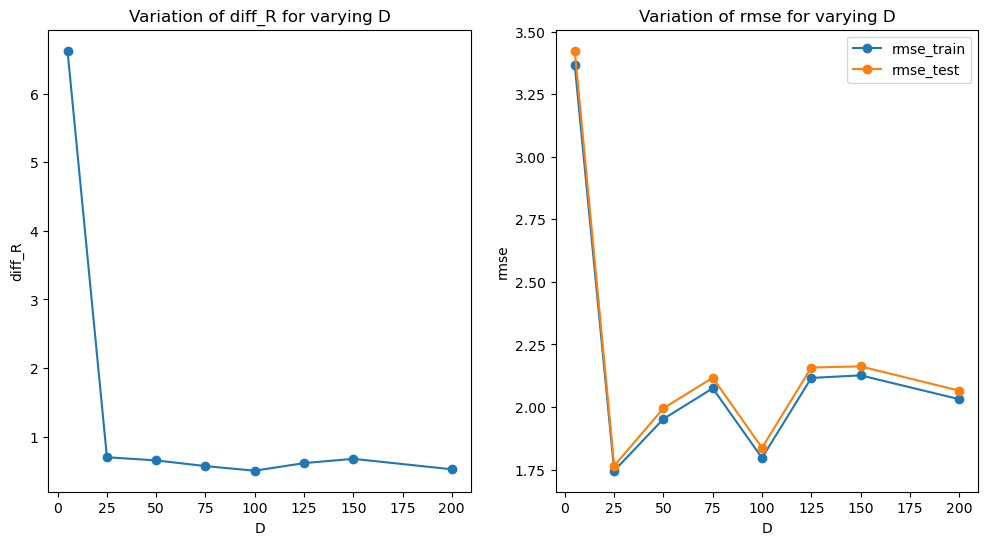

In [187]:
ratings_matrix, n_users, n_items = preprocess_data(ratings_df)
data = real_data_dimension_experiment(n_users, n_items, ratings_matrix)
plot_results(data, np.nan)

dimension d = 5
Log p a-posteriori at iteration 25 : -9.334587543656426
Log p a-posteriori at iteration 50 : -7.554626481161468
Log p a-posteriori at iteration 75 : -6.432089552938092
Log p a-posteriori at iteration 100 : -5.656115264572355
Log p a-posteriori at iteration 125 : -5.08746819303827
Log p a-posteriori at iteration 150 : -4.657923987057474
Log p a-posteriori at iteration 175 : -4.265855378233178
Log p a-posteriori at iteration 200 : -3.8814568111275545
Log p a-posteriori at iteration 225 : -3.634754266879789
Log p a-posteriori at iteration 250 : -3.430794743955239
Log p a-posteriori at iteration 275 : -3.256669696617358
Log p a-posteriori at iteration 300 : -3.1058864778820556
Log p a-posteriori at iteration 325 : -2.973864567127868
Log p a-posteriori at iteration 350 : -2.857183684964869
Log p a-posteriori at iteration 375 : -2.7532260705017686
Log p a-posteriori at iteration 400 : -2.6599506664467643
Log p a-posteriori at iteration 425 : -2.575740753314096
Log p a-posteri

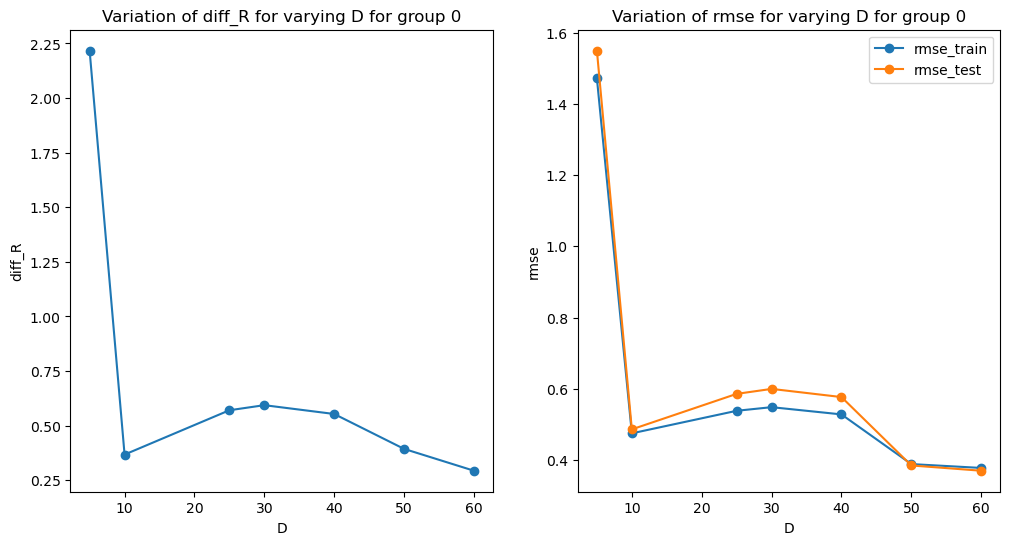

dimension d = 5
Log p a-posteriori at iteration 25 : -19.024833009808436
Log p a-posteriori at iteration 50 : -14.982110034643256
Log p a-posteriori at iteration 75 : -12.98542657579206
Log p a-posteriori at iteration 100 : -11.72860736002606
Log p a-posteriori at iteration 125 : -10.844222689266978
Log p a-posteriori at iteration 150 : -10.179608984935486
Log p a-posteriori at iteration 175 : -9.657691140871785
Log p a-posteriori at iteration 200 : -9.234632365445034
Log p a-posteriori at iteration 225 : -8.883379027552989
Log p a-posteriori at iteration 250 : -8.586201330937119
Log p a-posteriori at iteration 275 : -8.330928827621038
Log p a-posteriori at iteration 300 : -8.10889273581215
Log p a-posteriori at iteration 325 : -7.913729060551335
Log p a-posteriori at iteration 350 : -7.740646677526884
Log p a-posteriori at iteration 375 : -7.585960871127543
Log p a-posteriori at iteration 400 : -7.446785533381007
Log p a-posteriori at iteration 425 : -7.320823933536713
Log p a-posteri

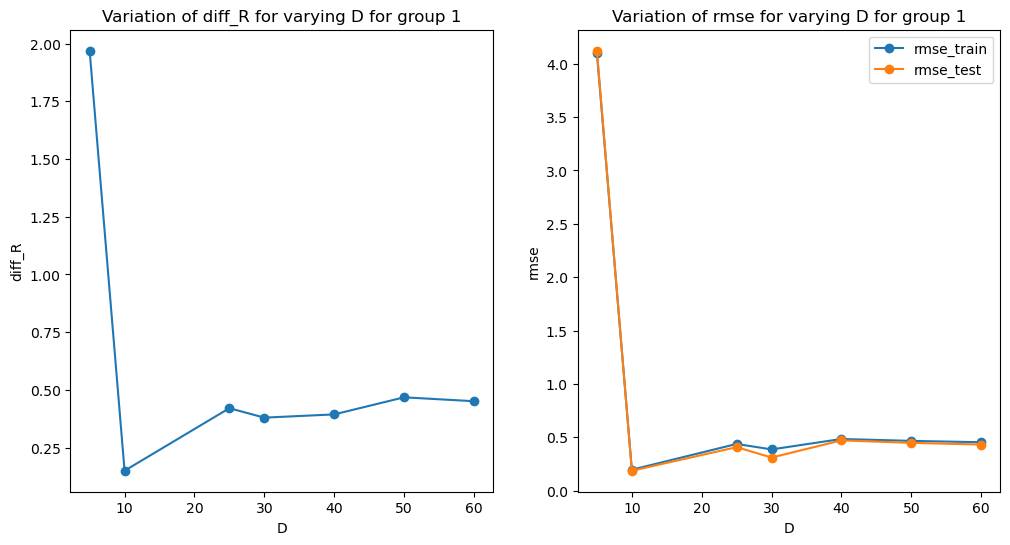

dimension d = 5
Log p a-posteriori at iteration 25 : -4.435289406561656
Log p a-posteriori at iteration 50 : -3.593670427331105
Log p a-posteriori at iteration 75 : -3.1720545227393515
Log p a-posteriori at iteration 100 : -2.8994491998930902
Log p a-posteriori at iteration 125 : -2.7039711255608783
Log p a-posteriori at iteration 150 : -2.5555407902499603
Log p a-posteriori at iteration 175 : -2.4385987225621637
Log p a-posteriori at iteration 200 : -2.3440001555165235
Log p a-posteriori at iteration 225 : -2.265906649503354
Log p a-posteriori at iteration 250 : -2.200374513157015
Log p a-posteriori at iteration 275 : -2.1446295390389505
Log p a-posteriori at iteration 300 : -2.0966587112211785
Log p a-posteriori at iteration 325 : -2.054964501837542
Log p a-posteriori at iteration 350 : -2.0184095257015846
Log p a-posteriori at iteration 375 : -1.9861145069266326
Log p a-posteriori at iteration 400 : -1.9573891706584323
Log p a-posteriori at iteration 425 : -1.9316842220819326
Log p 

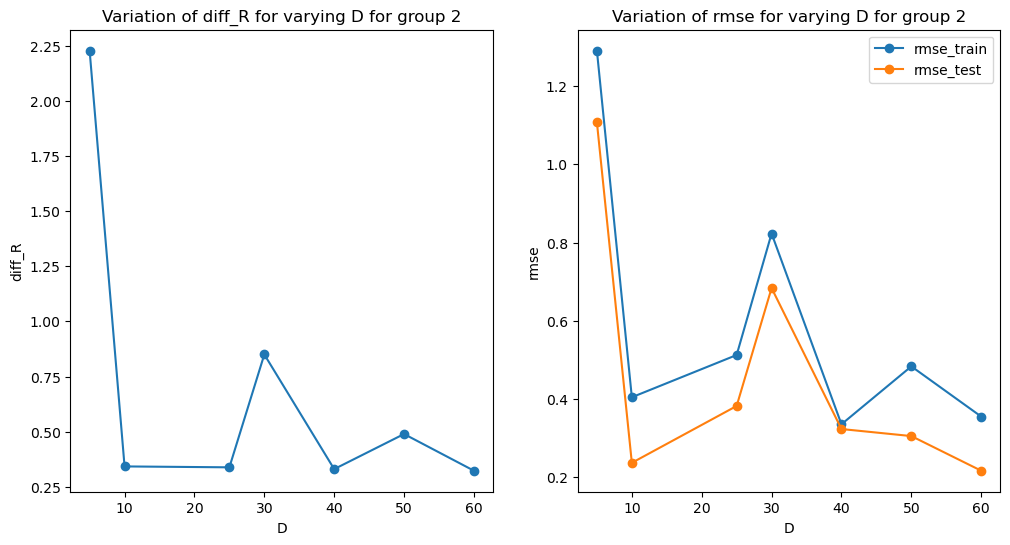

dimension d = 5
Log p a-posteriori at iteration 25 : -7.120216793231244
Log p a-posteriori at iteration 50 : -6.0904408085589266
Log p a-posteriori at iteration 75 : -5.6995377828017535
Log p a-posteriori at iteration 100 : -5.449807327082212
Log p a-posteriori at iteration 125 : -5.17070024868826
Log p a-posteriori at iteration 150 : -5.041161318031951
Log p a-posteriori at iteration 175 : -4.983128544234104
Log p a-posteriori at iteration 200 : -4.954587971822387
Log p a-posteriori at iteration 225 : -4.9389549527142735
Log p a-posteriori at iteration 250 : -4.930042115468843
Log p a-posteriori at iteration 275 : -4.925036172852955
10 80
[10, 80, 5, 3.9626415530732157, 1.8584293323340004, 2.043045414257125]
dimension d = 10
Log p a-posteriori at iteration 25 : -2.468219110507496
Log p a-posteriori at iteration 50 : -1.728988066375631
Log p a-posteriori at iteration 75 : -1.3857225146473682
Log p a-posteriori at iteration 100 : -1.1713573914491981
Log p a-posteriori at iteration 125 :

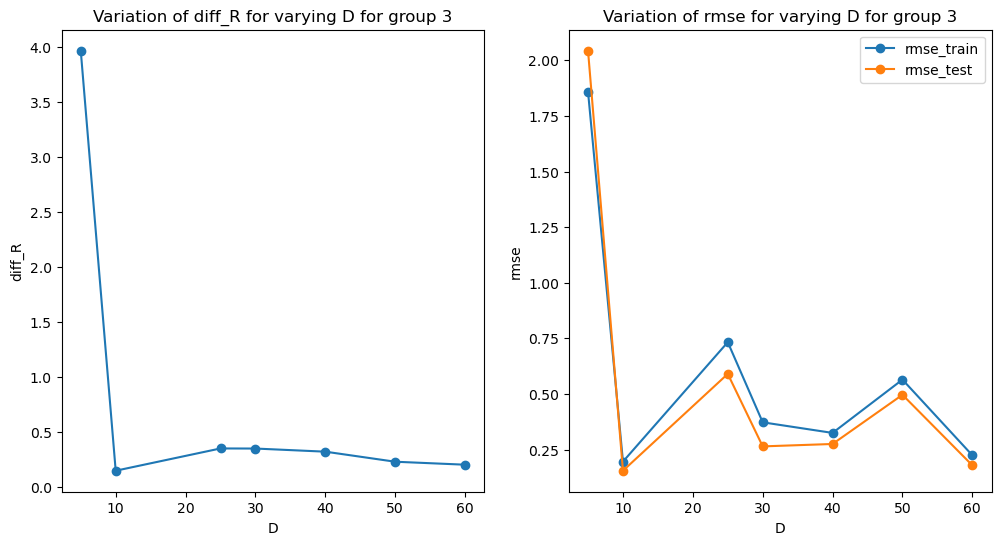

dimension d = 5
Log p a-posteriori at iteration 25 : -1.93026036444644
Log p a-posteriori at iteration 50 : -1.167828112306955
Log p a-posteriori at iteration 75 : -0.8604221048278434
Log p a-posteriori at iteration 100 : -0.6868684076412103
Log p a-posteriori at iteration 125 : -0.5736672842011759
Log p a-posteriori at iteration 150 : -0.49350597503877586
Log p a-posteriori at iteration 175 : -0.43359751581725064
Log p a-posteriori at iteration 200 : -0.38707086319691647
Log p a-posteriori at iteration 225 : -0.349875579813031
Log p a-posteriori at iteration 250 : -0.3194583097758534
Log p a-posteriori at iteration 275 : -0.2941250226583538
Log p a-posteriori at iteration 300 : -0.272705450240285
Log p a-posteriori at iteration 325 : -0.2543641410664671
Log p a-posteriori at iteration 350 : -0.23848816107907947
Log p a-posteriori at iteration 375 : -0.22461732893582123
Log p a-posteriori at iteration 400 : -0.21239924322481438
Log p a-posteriori at iteration 425 : -0.2015593665040466


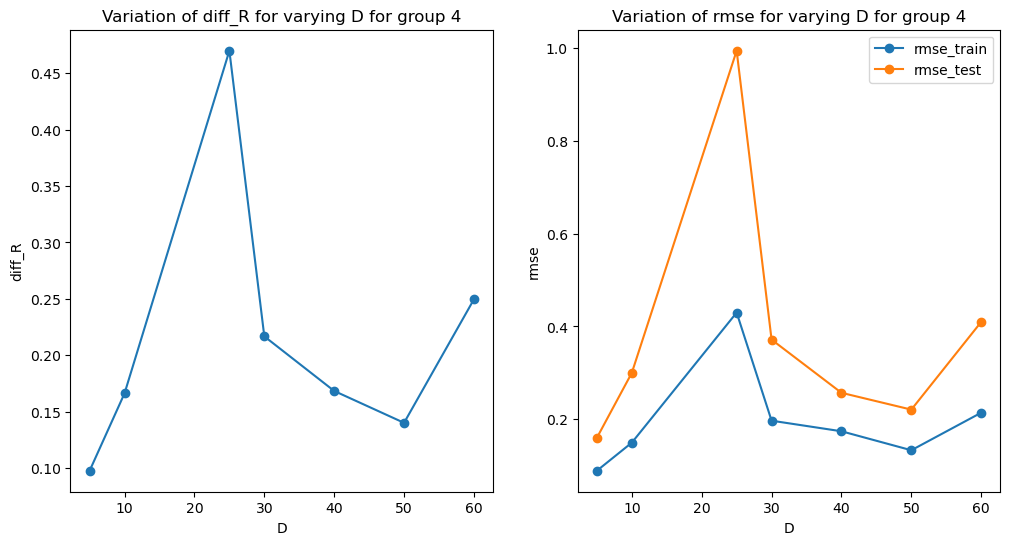

In [217]:
group_dfs = [group_0_df, group_1_df, group_2_df, group_3_df, group_4_df]
group_nbrs = [0, 1, 2, 3, 4]

for group_df, group_nbr in zip(group_dfs, group_nbrs):
    ratings_matrix, n_users, n_items = preprocess_data(group_df)
    data = real_data_dimension_experiment(n_users, n_items, ratings_matrix)
    plot_results(data, group_nbr)


Now let's take a look at some graphs

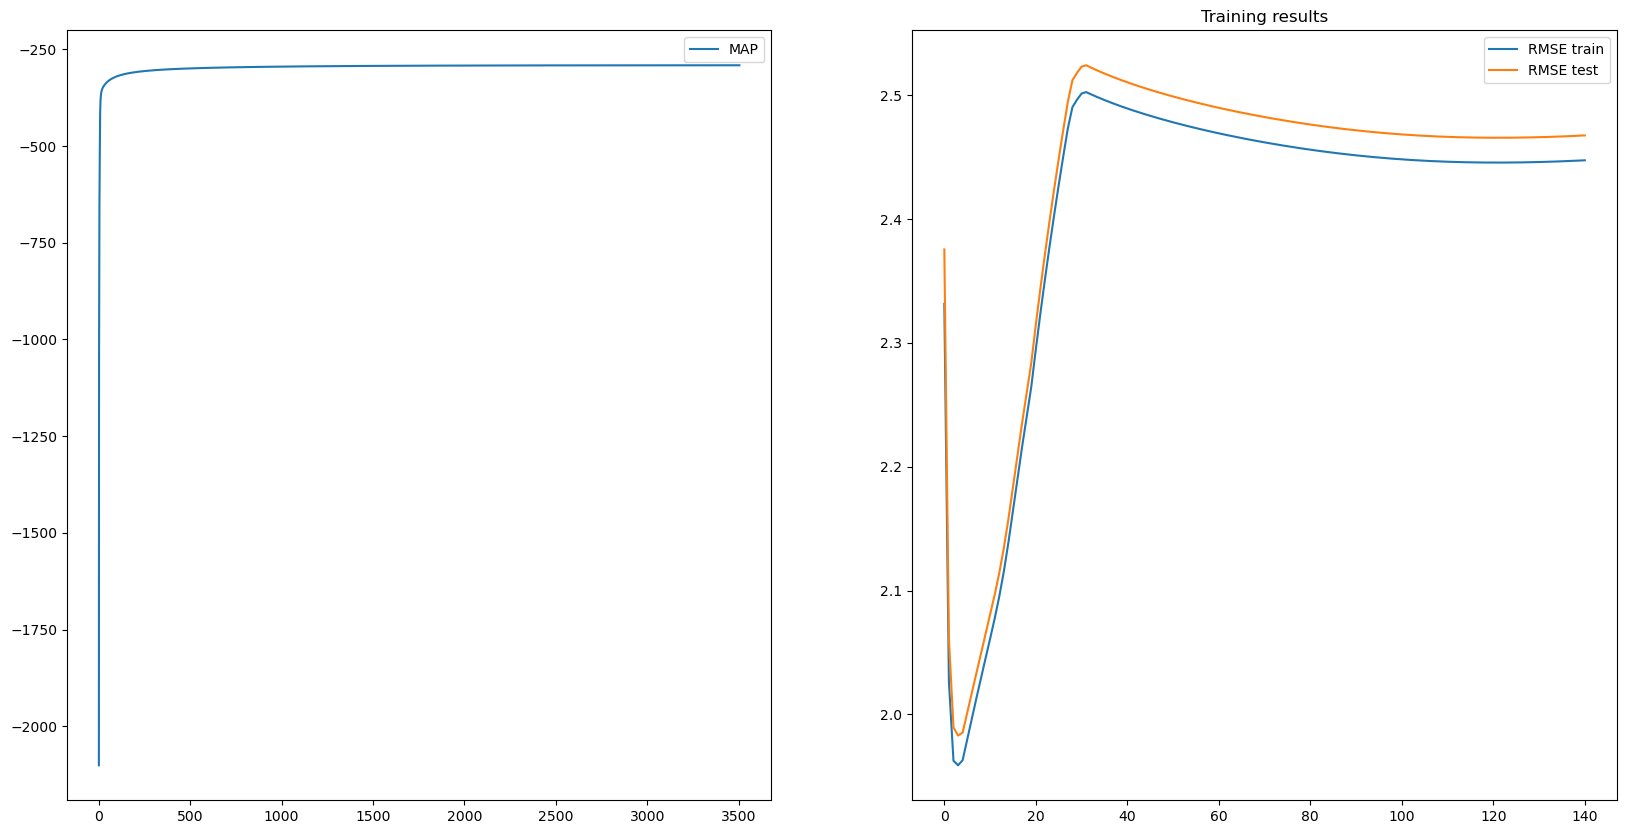

[2.3315107136118596, 2.0265240520812453, 1.9626600198871154, 1.9589888577116676, 1.9631013509113586, 1.9798470987973649, 1.9964822149000814, 2.0129616258862306, 2.02918804301975, 2.045155918784123, 2.0610618208329177, 2.077406305354937, 2.095090262077987, 2.115298485970387, 2.138685168623693, 2.1644041476125553, 2.1906760611841505, 2.216156705079185, 2.2403310569904393, 2.264379742106204, 2.2949010795526146, 2.3238911233784427, 2.3515152754325026, 2.3779099707272677, 2.4031887563834475, 2.4274475419286645, 2.4507685707677225, 2.473223302317647, 2.490398288252308, 2.4963974753680027, 2.501361486663939, 2.5025376681750533, 2.5008314765649824, 2.499197392451757, 2.497628005106721, 2.496117114714264, 2.4946594866214875, 2.4932506623219814, 2.4918868127419835, 2.490564623417586, 2.489281203953763, 2.48803401613945, 2.4868208165129126, 2.4856396102023735, 2.4844886136231676, 2.483366224172773, 2.4822709954851057, 2.481201617122449, 2.4801568978244974, 2.4791357516196646, 2.478137186247018, 2

In [68]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_aps)), log_aps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()
plt.show()
print(rmse_train)

Let's now evaluate our model on both the training and testing sets.

In [69]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 2.447510720737315
RMSE of testing set: 2.467589149352373


Now we will pick a user from the database and look at his/her preferences.

In [1]:
user_id = 45
df_ratings[df_ratings['user_id'] == user_id].sort_values(by=['rating'], ascending=False).head(10)

NameError: name 'df_ratings' is not defined

Let's look at the least preferred items.

In [ ]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)